In [170]:
import pandas as pd
import datetime as dt

dataset = pd.read_csv('./data/BTC-Daily.csv')

# convert column date of dataset to datetime
dataset['date'] = pd.to_datetime(dataset['date'])

# filter dataset to get data from 2015-01-01 to 2016-12-31
dataset = dataset[(dataset['date'] >= dt.datetime(2017, 1, 1)) & (dataset['date'] <= dt.datetime(2018, 12, 31))]

# describe dataset
dataset.describe()

,unix,open,high,low,close,Volume BTC,Volume USD
count,7.300000e+02,730.000000,730.000000,730.000000,730.000000,7.300000e+02,7.300000e+02
mean,1.514722e+09,5743.299507,5942.587137,5506.783685,5747.232479,4.464699e+07,2.719435e+07
std,1.821978e+07,3743.447591,3909.576011,3512.200168,3739.943146,8.188029e+07,4.424850e+07
min,1.483229e+09,778.700000,823.450000,751.340000,788.810000,8.392977e+02,1.144750e+03
25%,1.498975e+09,2561.130000,2645.852500,2476.257500,2564.865000,9.448051e+03,1.093338e+04
50%,1.514722e+09,6202.620000,6349.735000,6063.640000,6201.965000,7.157146e+06,2.029128e+04
75%,1.530468e+09,7670.990000,7948.000000,7439.730000,7670.885000,5.134294e+07,4.252761e+07
max,1.546214e+09,19187.780000,19666.000000,18465.000000,19187.780000,7.723295e+08,2.928630e+08


In [171]:
import numpy as np

# preserve only open, high, low, close, volume usd columns
dataset = dataset[['open', 'high', 'low', 'close', 'Volume USD']]
dataset.describe()

,open,high,low,close,Volume USD
count,730.000000,730.000000,730.000000,730.000000,7.300000e+02
mean,5743.299507,5942.587137,5506.783685,5747.232479,2.719435e+07
std,3743.447591,3909.576011,3512.200168,3739.943146,4.424850e+07
min,778.700000,823.450000,751.340000,788.810000,1.144750e+03
25%,2561.130000,2645.852500,2476.257500,2564.865000,1.093338e+04
50%,6202.620000,6349.735000,6063.640000,6201.965000,2.029128e+04
75%,7670.990000,7948.000000,7439.730000,7670.885000,4.252761e+07
max,19187.780000,19666.000000,18465.000000,19187.780000,2.928630e+08


In [172]:
# extract close column
close = dataset['close'].copy().to_numpy()[1:]

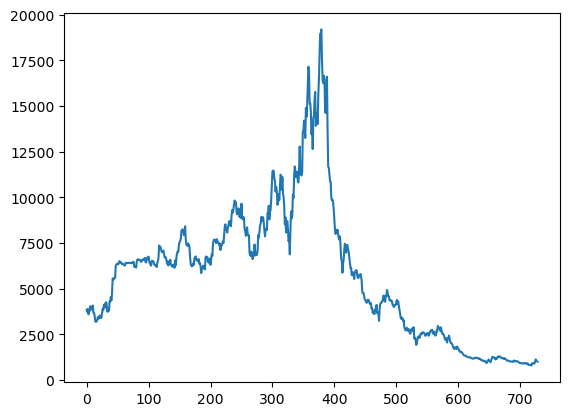

In [173]:
# plot close
import matplotlib.pyplot as plt
plt.plot(close)

In [174]:
from river import drift

# create drift detector
m_adwin = drift.ADWIN(
    delta=0.3,
    clock=1,
    min_window_length=3,
    grace_period=1
)

drifts = []

for i, val in enumerate(close):
    m_adwin.update(val)
    if m_adwin.drift_detected:
        drifts.append(i)

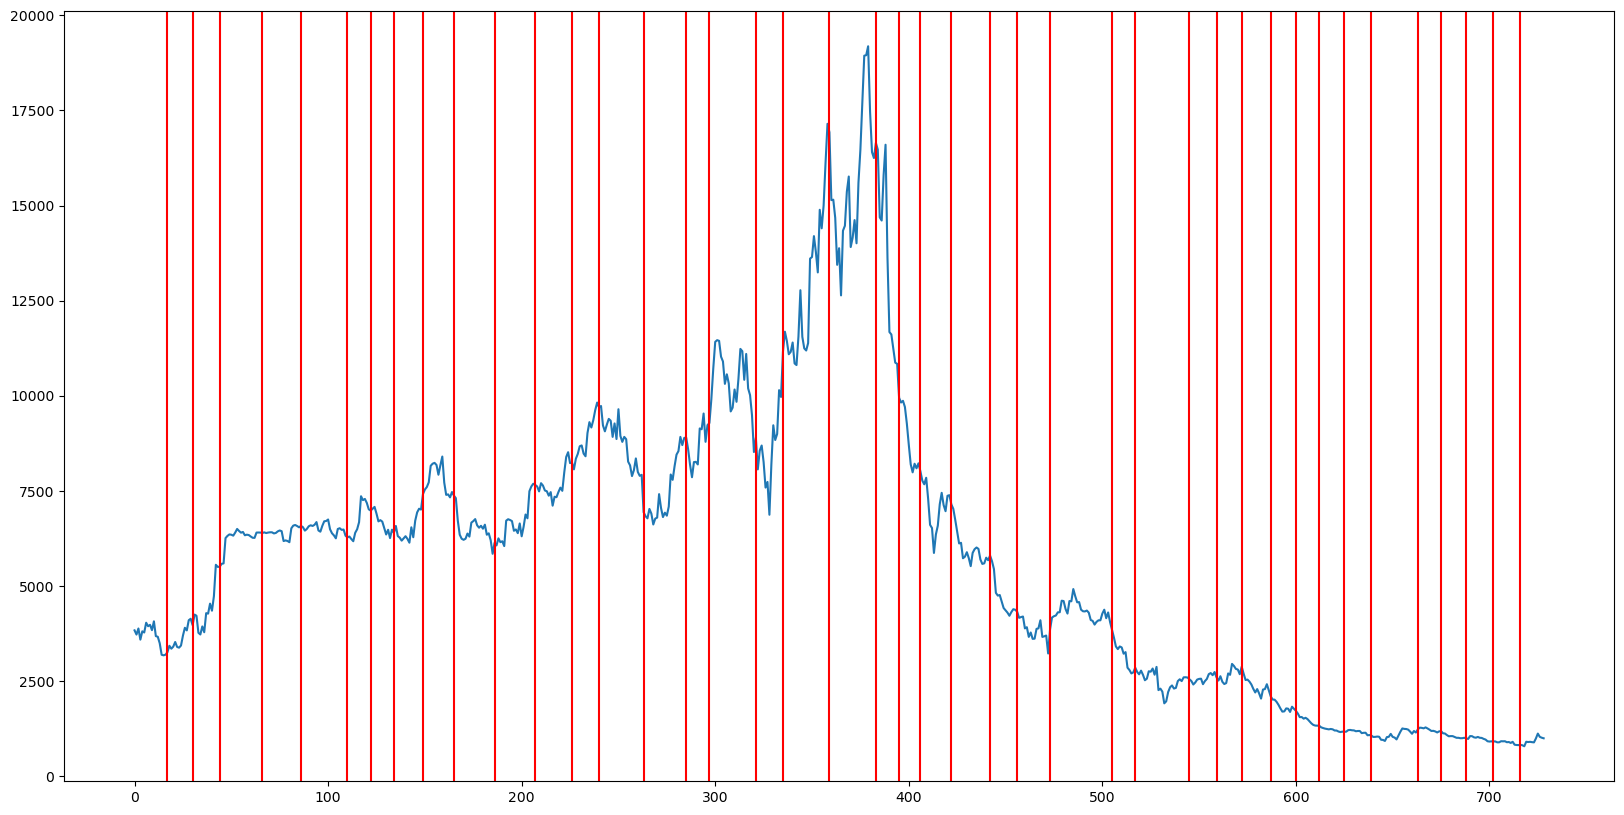

In [175]:
import matplotlib.pyplot as plt

# plot close and vertical lines for drifts, fill the width of the screen
plt.figure(figsize=(20, 10))
plt.plot(close)
for drift in drifts:
    plt.axvline(x=drift, color='r')

MAE: 509.067171


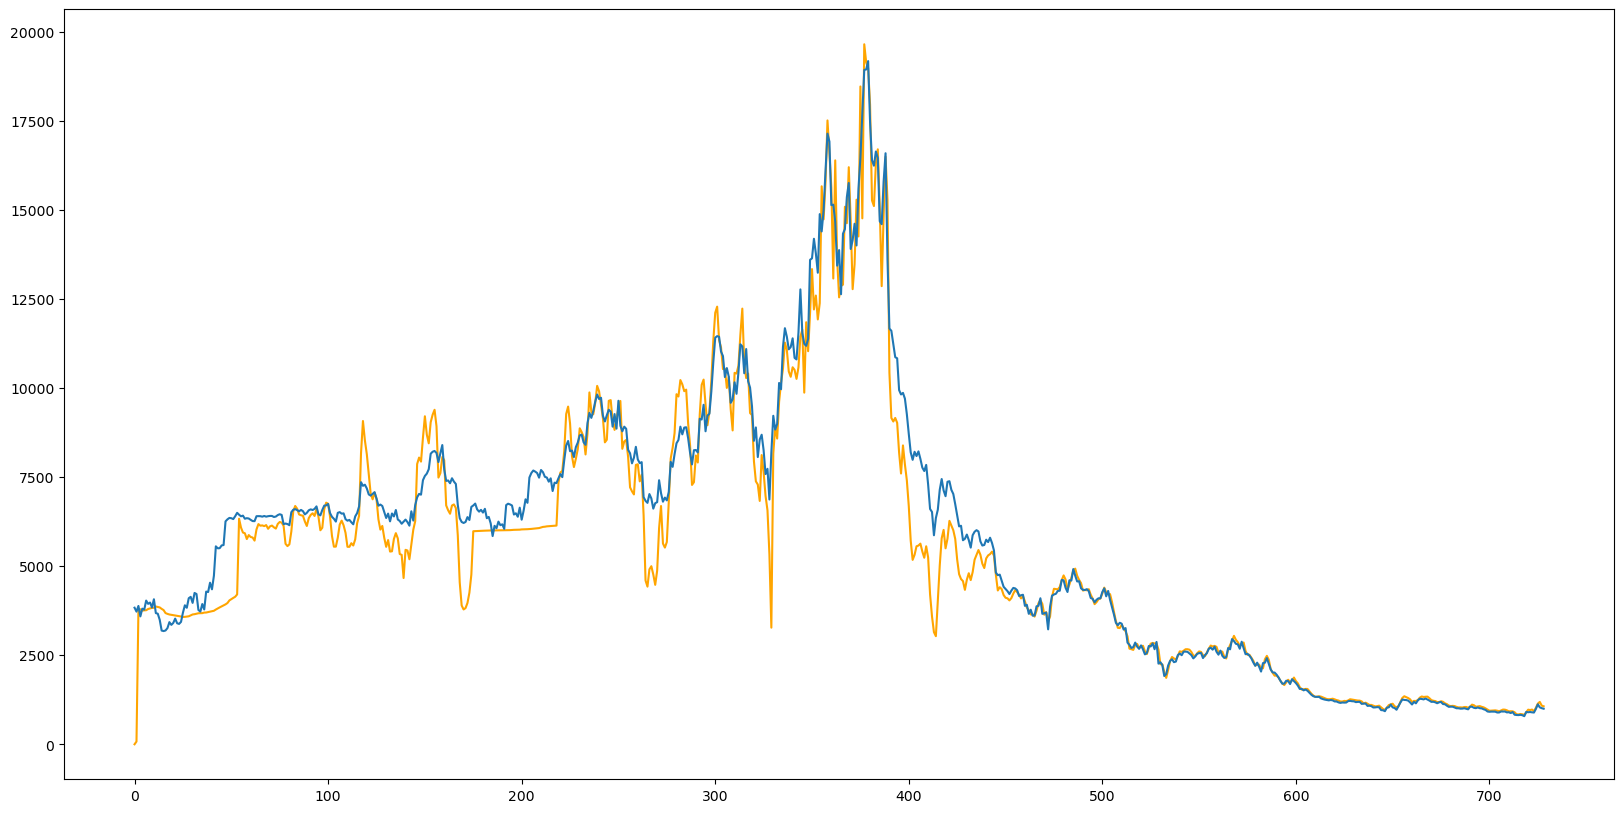

In [176]:
from river import tree
from river import evaluate
from river import metrics
from river import preprocessing

# create decision tree regressor
model = preprocessing.StandardScaler() | tree.HoeffdingAdaptiveTreeRegressor(
    drift_detector=m_adwin
)


samples = { i: dataset.to_numpy()[:-1][i] for i in range(len(dataset) - 1) }

stream = [(dict(enumerate(samples[i])), close[i]) for i in range(len(dataset) - 1)]

metric = metrics.MAE()

predictions = []

i = 0
for x, y in stream:
    i += 1
    y_pred = model.predict_one(x)
    predictions.append(y_pred)
    model.learn_one(x, y)
    if i >= 60:
        metric = metric.update(y, y_pred)

print(metric)

plt.figure(figsize=(20, 10))
plt.plot(np.array(predictions), color='orange')
plt.plot(close)

MAE: 310.182186


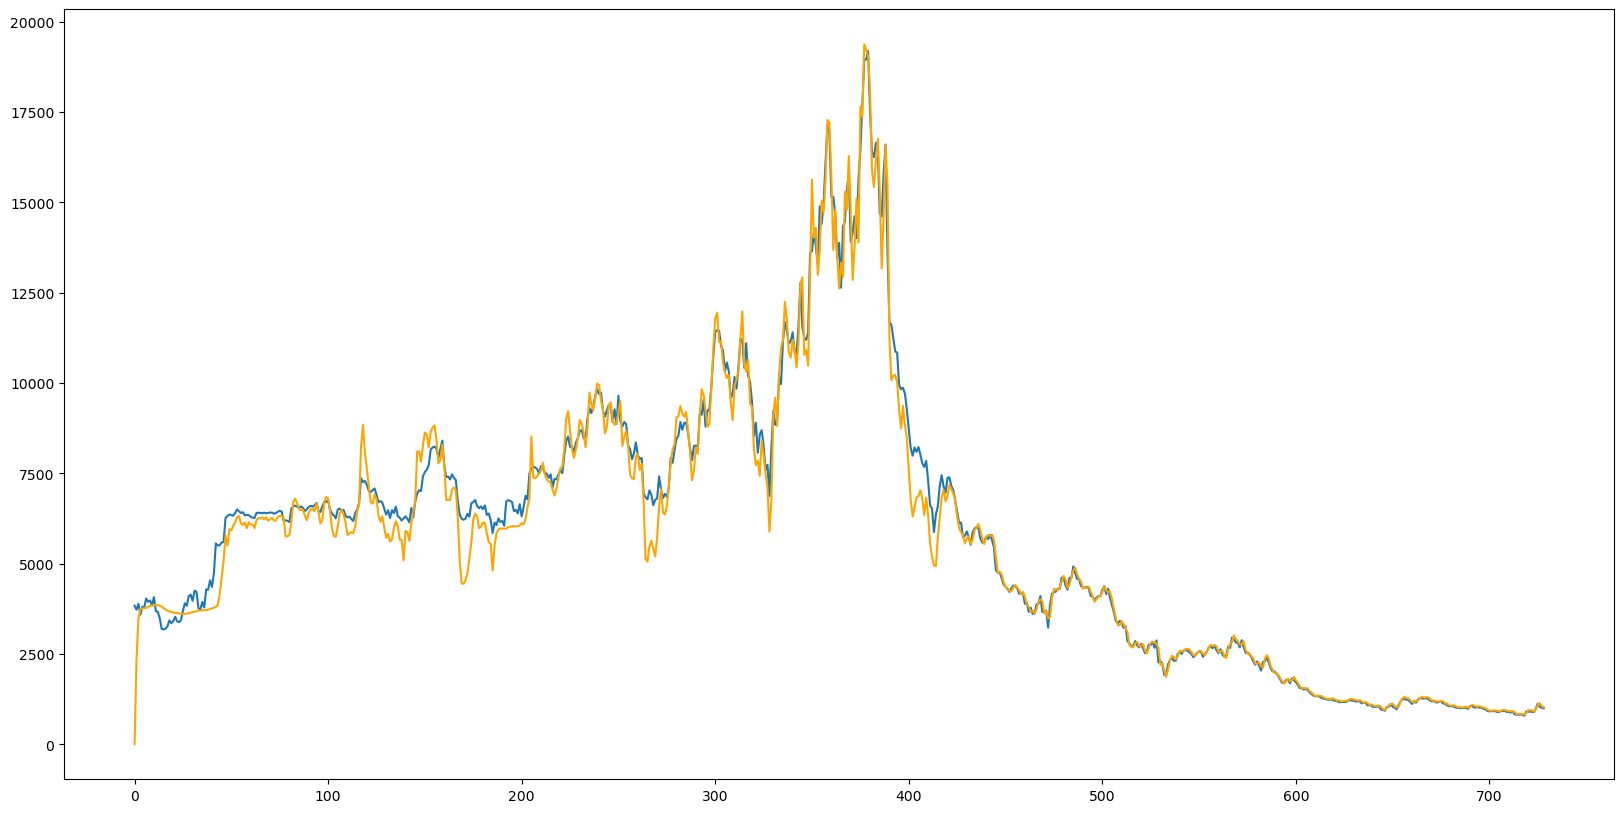

In [177]:
from river import drift

# generate n concept drift detectors
n = 100

adwins = [
    drift.ADWIN(
        delta=0.05,
        clock=1,
        min_window_length=i+3
    ) for i in range(n)
]

# generate n decision tree regressors
models = [
    preprocessing.StandardScaler() | tree.HoeffdingAdaptiveTreeRegressor(
        drift_detector=adwins[i]
    ) for i in range(n)
]

class random_forest:
    def __init__(self, models):
        self.models = models

    def learn_one(self, x, y):
        idxs = np.random.choice(len(self.models), int(np.floor(2 * len(self.models))))
        for idx in idxs:
            self.models[idx].learn_one(x, y)

    def predict_one(self, x):
        return np.mean(np.array([self.models[i].predict_one(x) for i in range(len(self.models))]))

rf = random_forest(models)

predictions = []

metric = metrics.MAE()

for x, y in stream:
    y_pred = rf.predict_one(x)
    predictions.append(y_pred)
    rf.learn_one(x, y)
    metric = metric.update(y, y_pred)

print(metric)

plt.figure(figsize=(20, 10))
plt.plot(close)
plt.plot(predictions, color='orange')
plt.show()